In [58]:
import glob
import os
import string

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, models, layers, callbacks, optimizers

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [7]:
maxlen = np.max([len(name) for name in names.name])
n_languages = len(names.lang.unique())
print("Maximum name length: ", maxlen)
print("Number of languages: ", n_languages)

Maximum name length:  18
Number of languages:  5


In [8]:
## Own alternative
alphabet = sorted(set([t for name in names.name for t in name]))
alphabet.append("END")
char_index = dict((c, i) for i, c in enumerate(alphabet))
len_alphabet = len(alphabet)

print("Alphabet length")
print(len(alphabet), "\n")

print("Alphabet")
print(alphabet, "\n")

print("Char index")
print(char_index, "\n")

Alphabet length
74 

Alphabet
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END'] 

Char index
{' ': 0, "'": 1, 'A': 2, 'B': 3, 'C': 4, 'D': 5, 'E': 6, 'F': 7, 'G': 8, 'H': 9, 'I': 10, 'J': 11, 'K': 12, 'L': 13, 'M': 14, 'N': 15, 'O': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27, 'a': 28, 'b': 29, 'c': 30, 'd': 31, 'e': 32, 'f': 33, 'g': 34, 'h': 35, 'i': 36, 'j': 37, 'k': 38, 'l': 39, 'm': 40, 'n': 41, 'o': 42, 'p': 43, 'q': 44, 'r': 45, 's': 46, 't': 47, 'u': 48, 'v': 49, 'w': 50, 'x': 51, 'y': 52, 'z': 53, 'Á': 54, 'É': 55, 'ß': 56, 'à': 57, 'á': 58, 'ä': 59, 'ç': 60, 'è': 61, 'é': 62, 'ê': 63, 'ì': 64, 'í': 65,

In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

In [10]:
print(names.groupby('lang')['name'].count())

print("number of names:", names.shape[0])

lang
English    3668
French      277
German      724
Italian     709
Spanish     298
Name: name, dtype: int64
number of names: 5676


### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [11]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length)
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2
np.random.seed(1)

### START YOUR CODE
# Shuffle and split names data

print("# Names",len(names))
train = names.sample(frac=1-test_split)

test = names.drop(train.index)

print("Length training data", len(train))

print("Length test data", len(test))
print("Length combined (check)", len(test)+len(train))

### END YOUR CODE

# Names 5676
Length training data 4541
Length test data 1135
Length combined (check) 5676


In [13]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = [name_representation(name, maxlen) for name in train.name]
Y_train = [lang_representation(language, language_to_index) for language in train.lang]

X_test = [name_representation(name, maxlen) for name in test.name]
Y_test = [lang_representation(language, language_to_index) for language in test.lang]

# The name
print("Name:", train.name[3321])
print("Length of encoding", len(X_train[0]), "\n")
print("Encoding of name")
print(X_train[0])

# We can see that the first array represents an 'M' with index 14. After 6 arrays the 'END' encoding is used until the length of the word with the max length.

### END YOUR CODE

Name: Murray
Length of encoding 18 

Encoding of name
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

#### Convert to Tensors

In [14]:
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)
X_test = tf.convert_to_tensor(X_test)
Y_test = tf.convert_to_tensor(Y_test)

2022-04-27 11:05:57.599569: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
labels = [index_to_language[i] for i in np.unique(np.argmax(Y_test, axis=1))]
print("labels:", labels)

labels: ['German', 'French', 'English', 'Spanish', 'Italian']


Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Plot functions

In [15]:
def plot_metrics(
        model: Sequential,
        logs: callbacks.History,
        ax: plt.Axes = None,
        color: str = None,
        display_train_accuracy: bool = True,
        display_train_loss: bool = False,
        display_val_accuracy: bool = True,
        display_val_loss: bool = False
) -> None:
    single_plot: bool = ax is None
    fig = None

    if single_plot:
        fig = plt.figure(figsize=(12, 7))
        ax = fig.add_subplot(1,1,1)

    if display_train_accuracy:
        ax.plot(logs.history['accuracy'], linestyle="--", label=f"Acc_Train_{model.name}", color=color)

    if display_train_loss:
        ax.plot(logs.history['loss'], linestyle="--", label=f"Loss_Train_{model.name}", color=color)

    if display_val_accuracy:
        ax.plot(logs.history['val_accuracy'], linestyle="-", label=f"Acc_Val_{model.name}", color=color)

    if display_val_loss:
        ax.plot(logs.history['val_loss'], linestyle="-", label=f"Loss_Val_{model.name}", color=color)

    if not display_val_loss and not display_train_loss:
        ax.set_ylim(0, 1)

    if single_plot:
        fig.suptitle("Metrics Plot")
        ax.set_xlabel("# Epochs")
        ax.set_ylabel("Accuracy / Loss")
        plt.legend()
        plt.show()


In [76]:
def plot_confusion_matrix(y_test: list, y_pred: list, labels: list, title: str = ""):

    print("-------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------")
    print(f"                 {title}")
    print("-------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------", "\n")

    t = np.argmax(y_test, axis=1)
    p = np.argmax(y_pred, axis=1)

    t = [index_to_language[i] for i in t]
    p = [index_to_language[i] for i in p]

    confm = confusion_matrix(t, p, labels=labels)

    print(confm)

    s = sns.heatmap(confm, xticklabels=labels, yticklabels=labels, cmap='Blues')
    s.set_xlabel("Predicted Values")
    s.set_ylabel("Actual Values")
    plt.show()


### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [16]:
### Configs
n_hidden: int = 64
batch_size: int =64
nepochs: int = 50
optimizer: str = 'adam'
metrics: list[str] = ['accuracy']
loss: str = 'categorical_crossentropy'

In [17]:
### START YOUR CODE

# SimpleRNN, single layer with tf.keras....

model: Sequential = Sequential(name="Single_Simple_RNN")

model.add(layers.SimpleRNN(units=n_hidden, input_shape=(maxlen, len_alphabet)))
model.add(layers.Dense(units=n_languages, activation='softmax'))

### END YOUR CODE

In [18]:
### START YOUR CODE
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()
### END YOUR CODE

Model: "Single_Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                8896      
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
_________________________________________________________________


In [19]:
log: callbacks.History = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/50
71/71 [==============================] - 2s 12ms/step - loss: 1.0832 - accuracy: 0.6441 - val_loss: 1.0128 - val_accuracy: 0.6581
Epoch 2/50
71/71 [==============================] - 0s 7ms/step - loss: 0.8952 - accuracy: 0.6965 - val_loss: 0.8773 - val_accuracy: 0.6952
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.8020 - accuracy: 0.7113 - val_loss: 0.8219 - val_accuracy: 0.7040
Epoch 4/50
71/71 [==============================] - 1s 8ms/step - loss: 0.7357 - accuracy: 0.7355 - val_loss: 0.7928 - val_accuracy: 0.7269
Epoch 5/50
71/71 [==============================] - 1s 8ms/step - loss: 0.7087 - accuracy: 0.7481 - val_loss: 0.7629 - val_accuracy: 0.7313
Epoch 6/50
71/71 [==============================] - 1s 8ms/step - loss: 0.6767 - accuracy: 0.7578 - val_loss: 0.7169 - val_accuracy: 0.7498
Epoch 7/50
71/71 [==============================] - 1s 8ms/step - loss: 0.6442 - accuracy: 0.7741 - val_loss: 0.6907 - val_accuracy: 0.7656
Epoch 8/50
71/71 [=

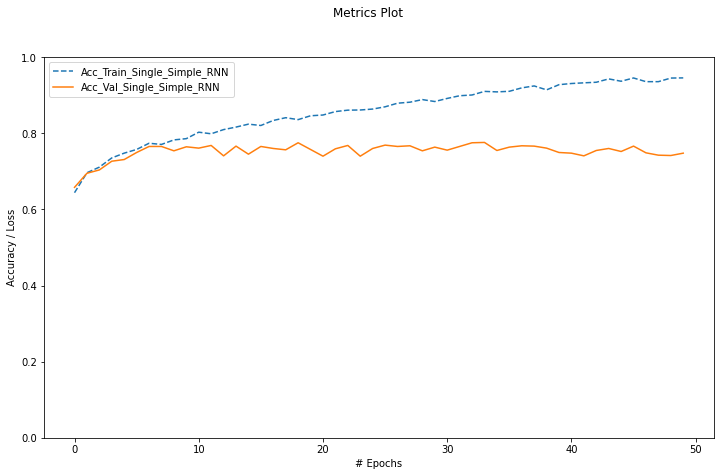

In [20]:
plot_metrics(model, log)

In [44]:
y_pred = model.predict(X_test)

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_512_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 61   0  74   1   4]
 [  4  11  42   4   3]
 [ 21  11 663   7  12]
 [  2   3  23  21  13]
 [  4  11  37  20  83]]


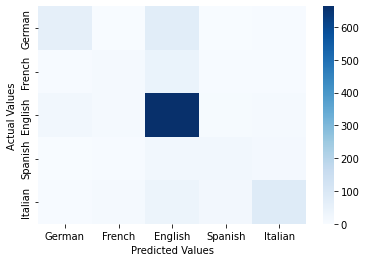

In [77]:
plot_confusion_matrix(Y_test, y_pred, labels, model.name)

#### Findings
With a single RNN layer only a rather limited result could be of around 74% could be achieved. This because english counts on its own for 65% of the data, so we consider that as baseline. Also it shows trend towards overfitting in the end. Now we want to explore how different sizes of hidden units change the result.

### Exploring different unit sizes

In [70]:
def train_single_layer_rnn(units: int, print_summary = True) -> tuple[Sequential, callbacks.History]:
    model: Sequential = Sequential(name=f"Single_Simple_RNN_{units}_units")

    model.add(layers.SimpleRNN(units=units, input_shape=(maxlen, len_alphabet)))
    model.add(layers.Dense(units=n_languages, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if print_summary:
        model.summary()

    log: callbacks.History = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, verbose=1, validation_data=(X_test, Y_test))

    return model, log


In [71]:
model_log_history: list[tuple[Sequential, callbacks.History]] = []

units_configs: list[int] = [16, 32, 64, 128, 256, 512]

for units in units_configs:
    model, logs = train_single_layer_rnn(units)
    model_log_history.append((model, logs))

Model: "Single_Simple_RNN_16_units"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                1456      
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 2s 8ms/step - loss: 1.4845 - accuracy: 0.3962 - val_loss: 1.2176 - val_accuracy: 0.6220
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 1.1219 - accuracy: 0.6472 - val_loss: 1.1255 - val_accuracy: 0.6291
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 1.0703 - accuracy: 0.6510 - val_loss: 1.1008 - val_accuracy: 0.6344
Epoch 4/50
71/

#### Plotting results of units evaluation

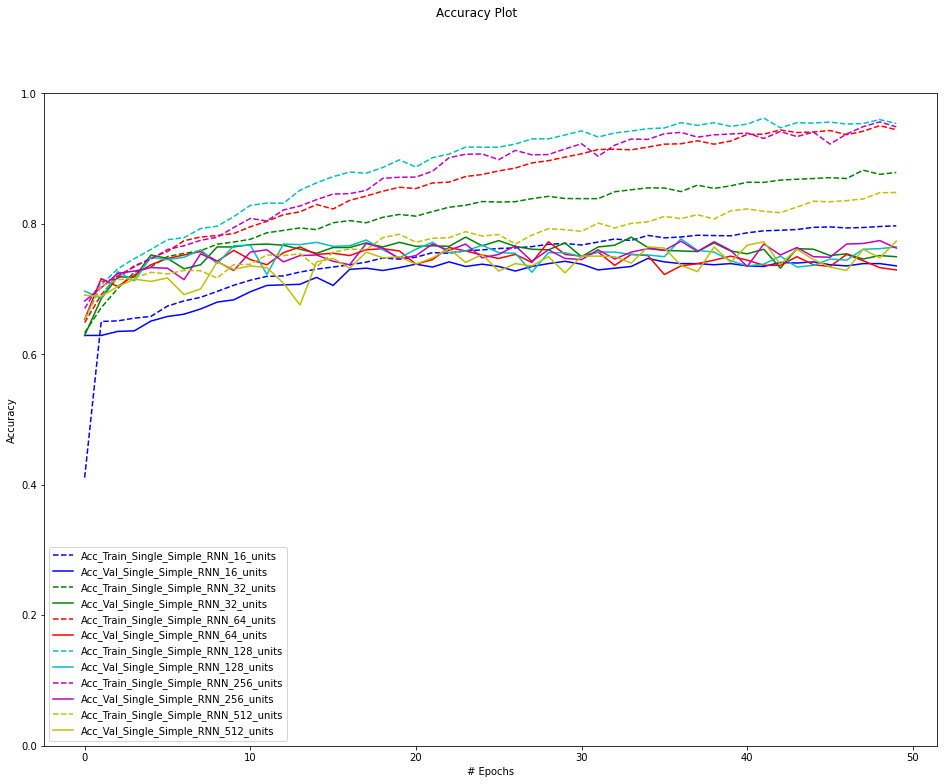

In [174]:
colors: list[str] = ['b', 'g', 'r', 'c', 'm', 'y']
fig: plt.Figure = plt.figure(figsize=(16, 12))
ax: plt.Axes = fig.add_subplot(1,1,1)

for i, entry in enumerate(model_log_history):
    plot_metrics(entry[0], entry[1], ax=ax, color=colors[i])

fig.suptitle("Accuracy Plot")
ax.set_xlabel("# Epochs")
ax.set_ylabel("Accuracy")
plt.legend()
plt.show()

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_16_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 57   1  72   5   5]
 [  4   1  41   2  16]
 [ 49   0 635   3  27]
 [ 11   0  22  10  19]
 [  8   3  47   2  95]]


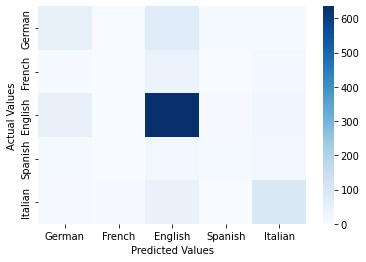

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_32_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 60   2  67   2   9]
 [  4   8  35   3  14]
 [ 29   6 652   8  19]
 [  3   2  13  15  29]
 [  7   3  17  18 110]]


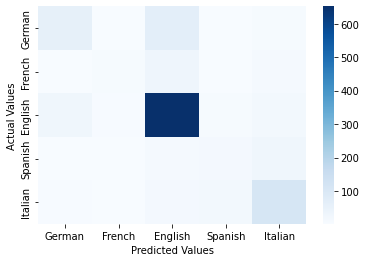

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_64_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 83   6  48   2   1]
 [ 11  11  32   4   6]
 [ 58  17 622   6  11]
 [  4   4  14  23  17]
 [  6  12  34  26  77]]


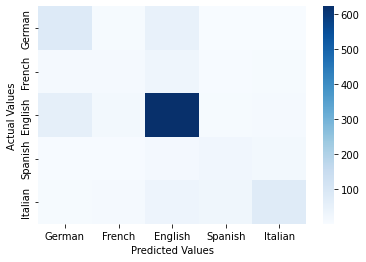

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_128_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 67   4  68   1   0]
 [  1  15  35   3  10]
 [ 31  13 656   2  12]
 [  3   2  16  23  18]
 [  3  13  23  12 104]]


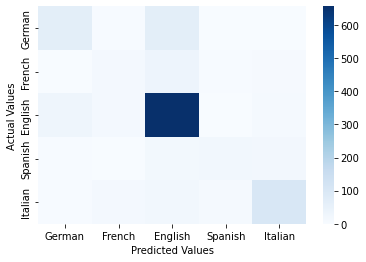

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_256_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 62   5  68   2   3]
 [  1  17  36   2   8]
 [ 21  11 663   4  15]
 [  2   5  15  22  18]
 [  1   8  25  12 109]]


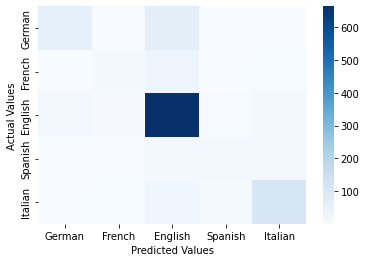

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Single_Simple_RNN_512_units
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 61   0  74   1   4]
 [  4  11  42   4   3]
 [ 21  11 663   7  12]
 [  2   3  23  21  13]
 [  4  11  37  20  83]]


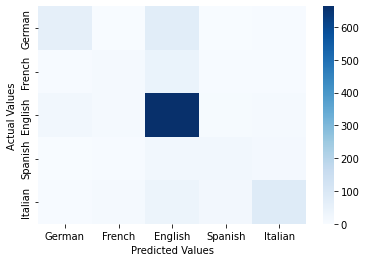

In [79]:
for i, entry in enumerate(model_log_history):
    y_pred = entry[0].predict(X_test)
    plot_confusion_matrix(Y_test, y_pred, labels, entry[0].name)

### Findings
The figure shows that even big differences in units sizes don't change the result radically. After 50 epochs they lie between 72% and 77% on the validation set.
With a rather small unit size of 16 (dark blue lines) the learning starts at a much lower level but then sticks much closer to the validation accuracy then with higher unit sizes. We can also not say that the higher the unit size the more we face the problem of overfitting. This because with a unit size of 512 (yellow line) we achieved a much lower training accuracy than for example with 128 units. Also interesting to see was that the trend towards overfitting rose with the number of units but then dropped again with a really large number of units. In the end we can say that with the increase of units we could marginally increase the validation accuracy but on our surprise not significantly.

The confusion matrices show that only english achieves a reasonable result. Maybe also Italien. But for the other languages it's more guessing between the dedicated language and english. The visual representation is not very useful becaus of the heavily overweighted English class.

### Implement Model with several SimpleRNN Layers

In [80]:
### START YOUR CODE

def train_multilayer_rnn(n_rnn_layers:int, units:int = 64):
    assert n_rnn_layers > 1, '1 layer is not multilayer ;)'

    # Instantiate model
    model: Sequential = Sequential(name=f"Mulilayer_Simple_RNN_{n_rnn_layers}_layers")

    # Add first rnn layer with specific input shape
    model.add(layers.SimpleRNN(units=units, input_shape=(maxlen, len_alphabet), return_sequences=True))

    # stacking additional layers
    n_additional_rnn_layers = tf.range(n_rnn_layers - 1)
    for i in n_additional_rnn_layers:
        model.add(layers.SimpleRNN(units=units, return_sequences=not i == len(n_additional_rnn_layers) - 1))

    # adding dense layer to classify languages
    model.add(layers.Dense(units=n_languages, activation='softmax'))

    # compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()

    # fitting the model
    log: callbacks.History = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, verbose=1, validation_data=(X_test, Y_test))

    return model, log

### END YOUR CODE

In [81]:
### START YOUR CODE
multilayer_log_history: list[tuple[Sequential, callbacks.History]] = []
n_layer_configs: list[int] = [2, 4, 6, 8, 10]

for n_layers in n_layer_configs:
    model, logs = train_multilayer_rnn(n_layers)
    multilayer_log_history.append((model, logs))

### END YOUR CODE

Model: "Mulilayer_Simple_RNN_2_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 18, 64)            8896      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17,477
Trainable params: 17,477
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 3s 13ms/step - loss: 1.0516 - accuracy: 0.6470 - val_loss: 0.9892 - val_accuracy: 0.6458
Epoch 2/50
71/71 [==============================] - 1s 8ms/step - loss: 0.8304 - accuracy: 0.7159 - val_loss: 0.8006 - val_accuracy: 0.7163
Epoch 3/50
71/71

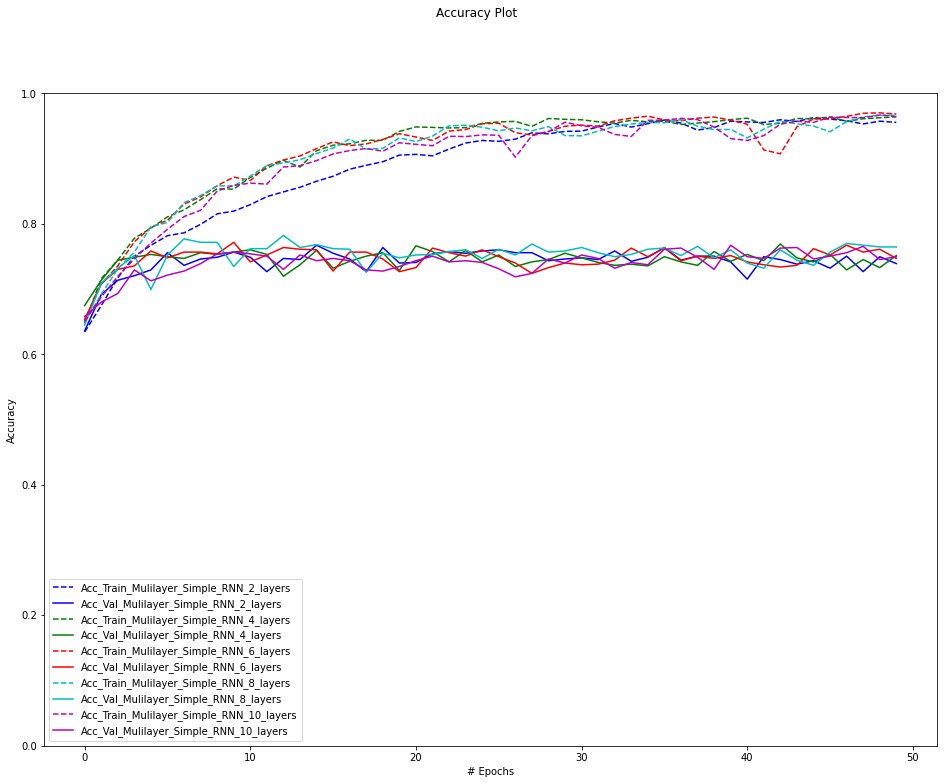

In [25]:
colors: list[str] = ['b', 'g', 'r', 'c', 'm', 'y']
fig: plt.Figure = plt.figure(figsize=(16, 12))
ax: plt.Axes = fig.add_subplot(1,1,1)

for i, entry in enumerate(multilayer_log_history):
    plot_metrics(entry[0], entry[1], ax=ax, color=colors[i])

fig.suptitle("Accuracy Plot")
ax.set_xlabel("# Epochs")
ax.set_ylabel("Accuracy")
plt.legend()
plt.show()

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Mulilayer_Simple_RNN_2_layers
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 81   7  48   2   2]
 [  7  16  31   4   6]
 [ 38  15 647   6   8]
 [  1   4  15  25  17]
 [  3   8  19  26  99]]


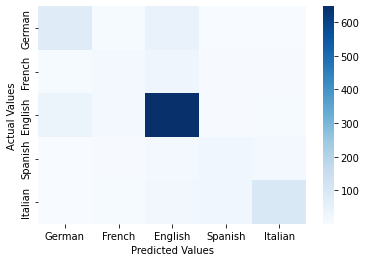

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Mulilayer_Simple_RNN_4_layers
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 62  10  65   1   2]
 [  2  13  38   3   8]
 [ 39  22 625   3  25]
 [  1   5  20  19  17]
 [  0   7  17  11 120]]


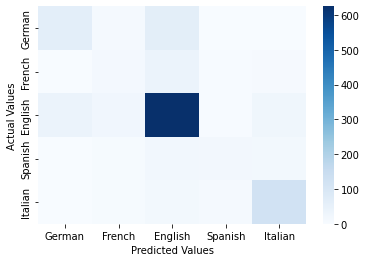

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Mulilayer_Simple_RNN_6_layers
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 65   6  67   1   1]
 [  5  18  38   3   0]
 [ 22  13 667   6   6]
 [  4   4  18  18  18]
 [  1   6  20  22 106]]


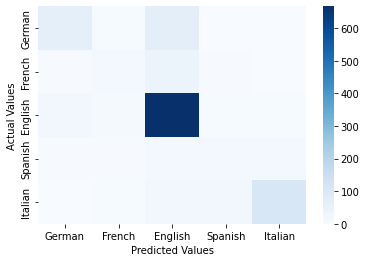

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Mulilayer_Simple_RNN_8_layers
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 77   7  55   0   1]
 [  8  14  36   2   4]
 [ 45  22 639   1   7]
 [  2   8  19  18  15]
 [  4  11  19  15 106]]


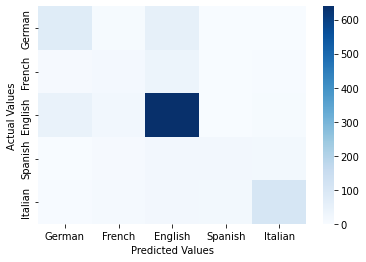

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Mulilayer_Simple_RNN_10_layers
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 69   8  59   3   1]
 [  4  15  38   4   3]
 [ 36  12 650   7   9]
 [  4   5  16  22  15]
 [  2   6  29  22  96]]


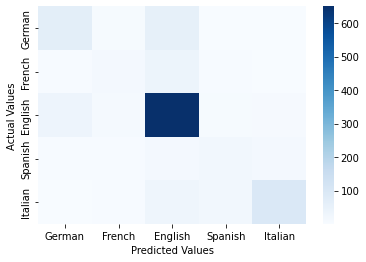

In [82]:
for i, entry in enumerate(multilayer_log_history):
    y_pred = entry[0].predict(X_test)
    plot_confusion_matrix(Y_test, y_pred, labels, entry[0].name)

#### Findings

Also with the increase of layers we can not achieve a significant raise in accuracy on this dataset. But it seems, that there are more spikes in the training accuracy with a larger number of layers than with smaller ones. This could be an indication of exploding gradients. So it could be a good idea to apply some regularization methods to ensure a more stable training. Also with all numbers of layers there could be still a slight trend of overfitting.

In the confusion matrices didn't changed much. It is hard to tell with a single run, if the changes are more likely a result of the different number of layers or just happening because it's a different run.

### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [83]:
### START YOUR CODE
from sklearn.utils.class_weight import compute_class_weight

class_series: np.array = np.argmax(Y_train, axis=1)

counts: np.array = np.bincount(class_series)

class_weights: dict = {i: 1.0 / counts[i] for i in range(len(counts))}

print(class_weights)

### END YOUR CODE

{0: 0.0017123287671232876, 1: 0.004694835680751174, 2: 0.00033852403520649965, 3: 0.00423728813559322, 4: 0.0018050541516245488}


In [84]:
model: Sequential = Sequential(name="Class_Weights_RNN")

model.add(layers.SimpleRNN(units=n_hidden, input_shape=(maxlen, len_alphabet)))
model.add(layers.Dense(units=n_languages, activation='softmax'))

# Tried to adding clipnorm because of large peaks
model.compile(optimizer=tf.keras.optimizers.Adam(clipnorm=1.0), loss=loss, metrics=metrics)

model.summary()

log: callbacks.History = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, verbose=1, validation_data=(X_test, Y_test),class_weight=class_weights)

Model: "Class_Weights_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_37 (SimpleRNN)   (None, 64)                8896      
                                                                 
 dense_12 (Dense)            (None, 5)                 325       
                                                                 
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
71/71 [==============================] - 2s 9ms/step - loss: 0.0017 - accuracy: 0.2325 - val_loss: 1.4702 - val_accuracy: 0.2608
Epoch 2/50
71/71 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 0.3147 - val_loss: 1.3428 - val_accuracy: 0.3454
Epoch 3/50
71/71 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 0.3948 - val_loss: 1.2556 - val_accuracy: 0.4520
Epoch 4/50
71/71 [=====

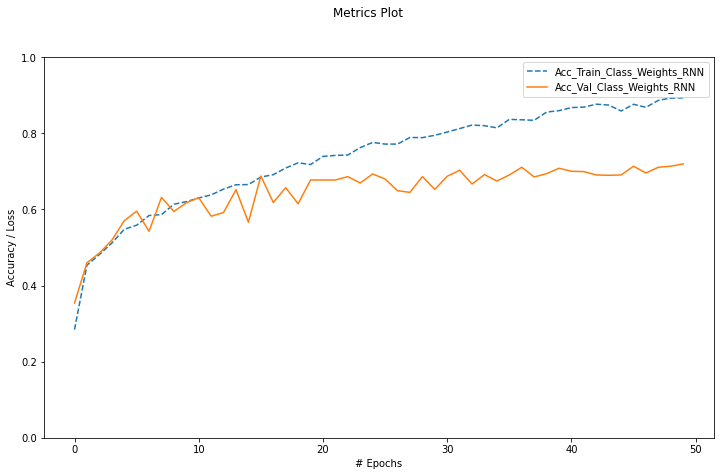

In [67]:
plot_metrics(model, log)

In [85]:
y_pred = model.predict(X_test)

-------------------------------------------------------------------------
-------------------------------------------------------------------------
                 Class_Weights_RNN
-------------------------------------------------------------------------
------------------------------------------------------------------------- 

[[ 78  13  39   4   6]
 [  8  21  18  10   7]
 [ 66  49 528  42  29]
 [  2   4   4  29  23]
 [  2   8  14  24 107]]


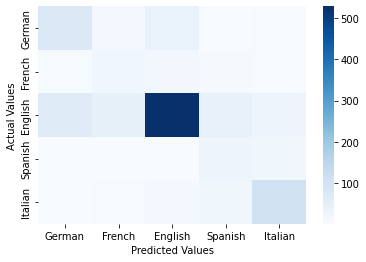

In [86]:
plot_confusion_matrix(Y_test, y_pred, labels, model.name)

### Findings
In our example we decided to use `class weights in the loss` inspired by the official keras example found [here](https://keras.io/examples/structured_data/imbalanced_classification/). Unfortunately it didn't help to achieve the desired result of a higher performance. Also it seems that the training isn't as stable as without using the keras class_weights property. Therefore we added a clipnorm of 1.0 to the adam optimizer. This reduced the problem slightly and increased the performance on average slightly. But with a accuracy of 71% it is even worse than without class weights and `minority resampling` may would be the better option.

But if we consider the confusion matrix we notice that may not the entire performance increased (because english decreased) but that the other languages are much more balanced. For example Italien and German improved in respect to wrongly predicting English.